In [1]:
import os
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
    os.chdir(Path(os.getcwd())/'..') # ew

from explain.gradcam_heatmap_timeseries import compute_binned_heatmaps_per_label_and_component, compute_gradcam_and_pca, plot_heatmaps_per_label_and_component, plot_all_trajectories_with_and_without_heatmaps
from explain.gradcam_heatmap_timeseries import compute_gradcam_per_sample, compute_projected_gradcam_activations, load_data_and_model, perform_pca_on_latent_vectors
from explain.gradcam_heatmap_timeseries import interactive_pca_heatmap_overlay_selection

from sklearn.preprocessing import MinMaxScaler

# enable autoreload     
%load_ext autoreload    
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
data_path = r"data\eog\EOG.parquet"
df = pd.read_parquet(data_path)

# Convert each row in 'dim_0' to a NumPy array, then stack them into a 2D array
X = np.stack(df['dim_0'].to_numpy())
# X shape: (n_samples, n_timesteps)

y = df['target'].values

In [ ]:
# Add a "channel" dimension at axis=1
X = np.expand_dims(X, axis=1)
print("X shape after expand_dims:", X.shape)
# e.g. (n_samples, 1, n_timesteps)

# Or if you want to save in the shape (n_samples, seq_len, 1), swap axes:
X_for_disk = np.swapaxes(X, 1, 2)  # Now shape: (n_samples, n_timesteps, 1)
print("X_for_disk shape:", X_for_disk.shape)

# Save these arrays to .npy
np.save("data/eog/time_series_positions.npy", X_for_disk)
np.save("data/eog/time_series_labels.npy", y)

X shape after expand_dims: (990, 1, 200)
X_for_disk shape: (990, 200, 1)


In [ ]:
# Define your parameters here
positions_path = 'data/eog/time_series_positions.npy'
labels_path = 'data/eog/time_series_labels.npy'

target_layer = 'encoder.0.layers.6'
device = 'cuda'  # or 'cuda' if you have a GPU
model_checkpoint_path = r'models/eog.ckpt'

In [5]:
import numpy as np
positions = np.load(positions_path, allow_pickle=True)
labels = np.load(labels_path, allow_pickle=True)
positions.shape, labels.shape

((990, 200, 1), (990,))

In [6]:
dataset, labels, unique_labels, model, gcam = load_data_and_model(
        positions_path, labels_path, model_checkpoint_path, target_layer, device
    )

gradcam_activations, sample_labels, mu_list, positions_array = compute_gradcam_per_sample(
    dataset, labels, model, gcam, device
)

pca, scores = perform_pca_on_latent_vectors(mu_list, n_components=2)
gradcam_projections = compute_projected_gradcam_activations(gradcam_activations, pca)

Positions shape after swapaxes: (990, 1, 200)
Labels shape: (990,)
Unique labels: ['3' '6' '7']
Computing Grad-CAM activations for all samples...


Grad-CAM Computation:  30%|██▉       | 293/990 [00:40<01:37,  7.15it/s]


KeyboardInterrupt: 

In [ ]:
heatmaps_dict, val_range, (global_min, global_max) = compute_binned_heatmaps_per_label_and_component(
    positions_array,
    gradcam_projections,
    sample_labels,
    unique_labels,
    n_components=2,   # same number of components
    grid_size=200,
    bin_stats='mean',
    sigma=5,
    normalize=True
)


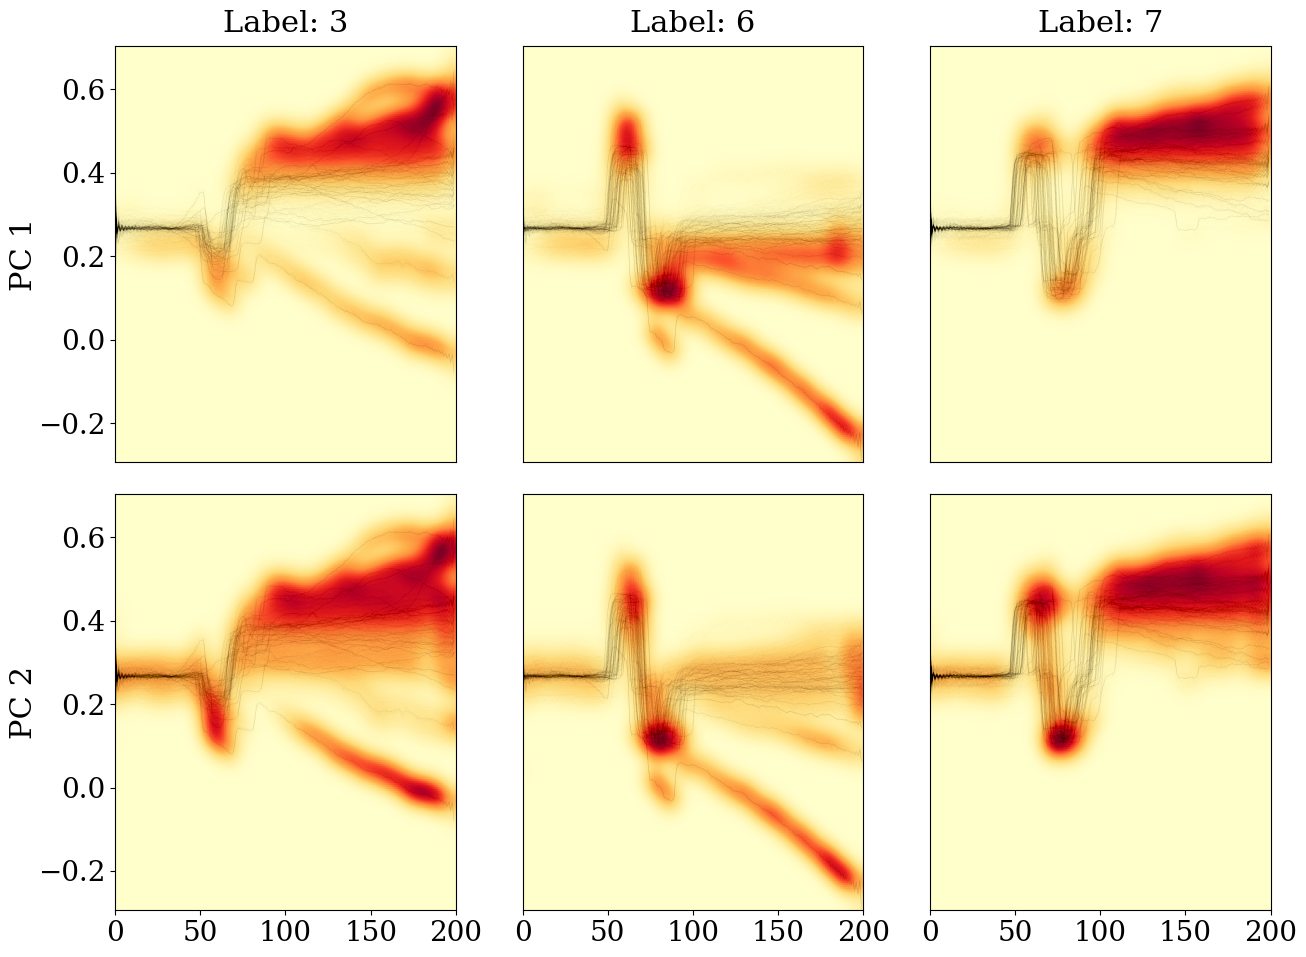

In [ ]:
import matplotlib.pyplot as plt
font_offset = 10
plt.rcParams.update({
    "text.usetex": False,          # Enable LaTeX rendering
    "font.family": "serif",       # Use serif fonts
    "font.size": 11 + font_offset,              # Base font size
    "axes.titlesize": 12 + font_offset,         # Titles slightly larger
    "axes.labelsize": 12 + font_offset,         # Axis labels size
    "xtick.labelsize": 10 + font_offset ,         # Tick labels size
    "ytick.labelsize": 10 + font_offset,
    "legend.fontsize": 11+ font_offset,
})


plot_heatmaps_per_label_and_component(
    heatmaps_dict,
    positions_array,
    sample_labels,
    unique_labels,
    n_components=2,
    val_range=val_range,
    global_extrema=(global_min, global_max),
    invert_y_axis=False
)


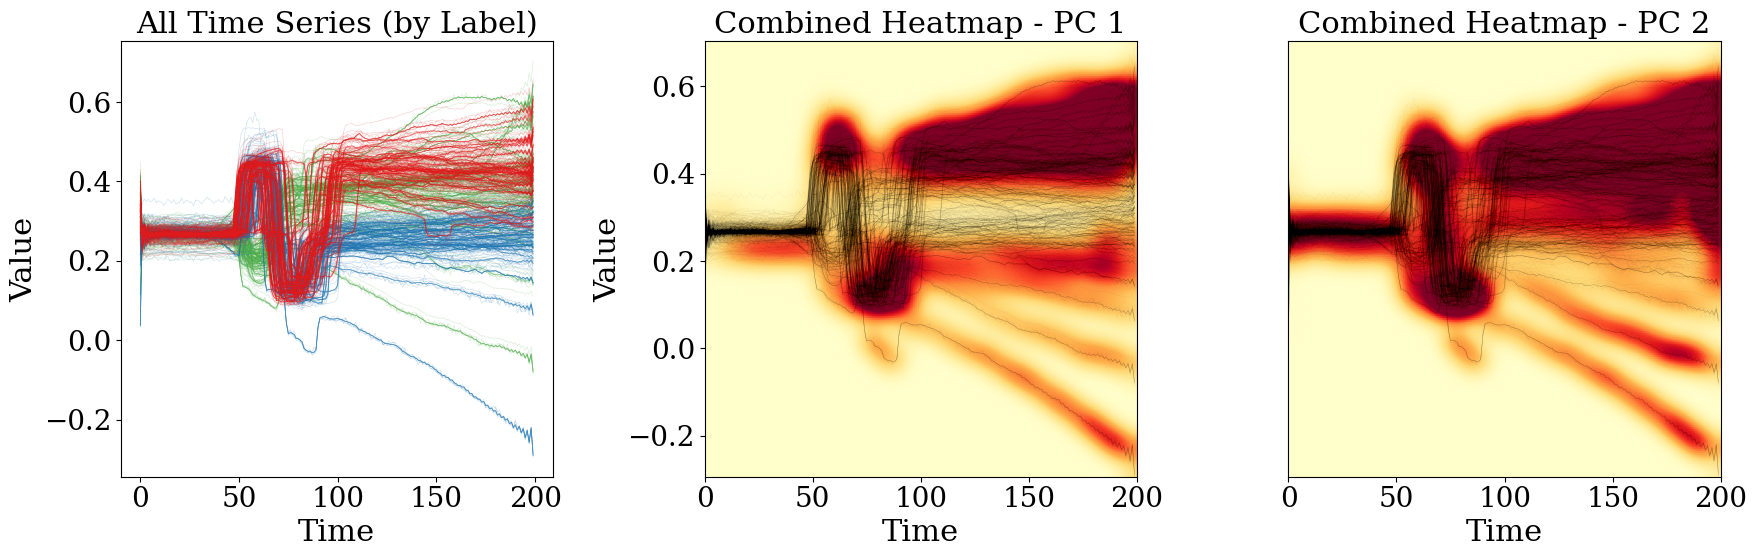

In [ ]:
plot_all_trajectories_with_and_without_heatmaps(
    heatmaps_dict,
    positions_array,
    sample_labels,
    unique_labels,
    n_components=2,
    val_range=val_range,
    global_extrema=(global_min, global_max),
    invert_y_axis=False
)


In [ ]:
import panel as pn

interactive_pca_heatmap_overlay_selection(
    scores,            # PCA scores (e.g., from perform_pca_on_latent_vectors)
    sample_labels,     # The sample labels array
    positions_array,   # The time series positions array
    gradcam_projections,  # The Grad-CAM projections array
    n_components=2     # (or your chosen number of components)
)


Launching server at http://localhost:59098
